# Dự đoán điểm chuẩn bằng máy học

In [306]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [307]:
# Đọc dữ liệu từ file CSV
benchmark_scores = pd.read_csv('../data/processed/benchmark_scores_2021_2023_cleaned.csv')
# Sao chép dữ liệu để xử lý
df = benchmark_scores.copy()

---

## Khám phá dữ liệu
Hiển thị một vài dòng đầu tiên của dữ liệu để kiểm tra cấu trúc.

In [308]:
df

,year,university_code,program_type,uni_major_code,major_code,major_name,subject_group_code,admission_method,score_scale,benchmark_score
0,2021,FTU2,DT,NTS01,7310101,Kinh tế,D01,Tốt nghiệp THPT,30,28.55
1,2021,GDU,DT,7380101,73801,Luật,A01,Tốt nghiệp THPT,30,15.00
2,2021,GDU,DT,7380101,73801,Luật,XDHB,Xét học bạ,30,16.50
3,2021,GDU,DT,7480201,74802,Công nghệ thông tin,A01,Tốt nghiệp THPT,30,16.00
4,2021,GDU,DT,7480201,74802,Công nghệ thông tin,A01,Tốt nghiệp THPT,30,16.50
...,...,...,...,...,...,...,...,...,...,...
7707,2023,VNUHCM-USSH,DT,7760101,7760101,Công tác xã hội,C00,Tốt nghiệp THPT,30,24.70
7708,2023,VNUHCM-USSH,DT,7760101,7760101,Công tác xã hội,DGNL,Đánh giá năng lực ĐHQG-HCM,1200,670.00
7709,2023,VNUHCM-USSH,DT,7810103,7810103,Quản trị dịch vụ du lịch và lữ hành,D01,Tốt nghiệp THPT,30,25.80
7710,2023,VNUHCM-USSH,DT,7810103,7810103,Quản trị dịch vụ du lịch và lữ hành,C00,Tốt nghiệp THPT,30,27.40


### Các feature và label
Dưới đây là danh sách các feature và label được sử dụng trong mô hình.

#### Các feature cho mô hình:
- `year`: Năm xét tuyển
- `university_code`: Mã trường đại học
- `program_type`: Loại chương trình đào tạo
- `major_code`: Mã ngành học
- `subject_group_code`: Mã tổ hợp môn
- `admission_method`: Phương thức tuyển sinh
#### Label:
- `benchmark_score`: Điểm chuẩn đầu vào

---

### Kiểm tra dữ liệu
Kiểm tra dữ liệu trùng lặp và giá trị bị thiếu.

In [309]:
# Kiểm tra dữ liệu trùng lặp
df.duplicated().any()

np.False_

In [310]:
# Kiểm tra giá trị bị thiếu
df.isna().any()

year                  False
university_code       False
program_type          False
uni_major_code        False
major_code            False
major_name            False
subject_group_code    False
admission_method      False
score_scale           False
benchmark_score       False
dtype: bool

---

## Tiền xử lý dữ liệu

Chuyển đổi thang điểm, loại bỏ dữ liệu trùng lặp và xử lý các giá trị ngoại lai.

In [311]:
df.nunique()

year                    3
university_code        45
program_type            2
uni_major_code        687
major_code            220
major_name            197
subject_group_code     56
admission_method        3
score_scale             2
benchmark_score       605
dtype: int64

- Ta có thể thấy số lượng unique value trong một số cột là rất nhiều, không thể One-hot encode hết   
-> Lấy các giá trị xuật hiện phổ biển và các giá trị còn lại sẽ gán là 'Other'

In [312]:
def group_top_n_labels(series, top_n=10):
    '''Giữ lại n dữ liệu xuất hiện nhiều nhất, còn lại sẽ được chuyển thành Other'''
    top_values = series.value_counts().nlargest(top_n).index
    return series.apply(lambda x: x if x in top_values else 'Other')

In [313]:
df['university_code'] = group_top_n_labels(df['university_code'],20)
df['major_code'] = group_top_n_labels(df['major_code'],40)
df['subject_group_code'] = group_top_n_labels(df['subject_group_code'],20)

drop_duplicated

In [314]:
# Trường hợp 1: Duplicated cả x và y
df.drop_duplicates(inplace=True)

# Trường hợp 2: Duplicated x nhưng lại khác y (duplicated features)
cols_X = ['year', 'university_code', 'major_code', 'subject_group_code', 'program_type', 'admission_method']
df.drop_duplicates(subset=cols_X, keep='first', inplace=True)

In [315]:
# Chuyển đổi thang điểm 1200 về thang điểm 30
df.loc[df['score_scale'] == 1200, 'benchmark_score'] = \
    df.loc[df['score_scale'] == 1200, 'benchmark_score'] * 30.0 / 1200.0

# Loại bỏ các cột không cần thiết
df.drop(columns=['score_scale', 'major_name', 'uni_major_code'], inplace=True)

# Loại bỏ các dòng trùng lặp
df.drop_duplicates(subset=['year', 'university_code', 'program_type', \
                          'subject_group_code', 'major_code', 'admission_method'], \
                 keep='first', inplace=True)

---

### Chọn các feature và label
Tách dữ liệu thành các feature (X) và label (y) để sử dụng trong mô hình.

In [316]:
# Hàm chọn feature và label
def select_features(df: pd.DataFrame, labels_columns: str = 'benchmark_score'):
    return df.drop(columns=labels_columns)

def select_labels(df, labels_columns: str = 'benchmark_score'):
    return df[labels_columns]

In [317]:
# Tách feature và label
features = select_features(df)
labels = select_labels(df)

---

### Mã hóa dữ liệu
Chuyển đổi các feature dạng category thành dạng one-hot encoding để sử dụng trong mô hình.

In [318]:
features.nunique()

year                   3
university_code       21
program_type           2
major_code            41
subject_group_code    21
admission_method       3
dtype: int64

In [319]:
# Chuyển đổi kiểu dữ liệu cho các cột
features[['year', 'major_code']] = \
    features[['year', 'major_code']].astype('str')

features[features.columns.to_list()] = \
    features[features.columns.to_list()].astype('category')

In [320]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

# Mã hóa các cột dạng category
ct = ColumnTransformer(transformers=[
    ('encoder', OneHotEncoder(), ['year', 'university_code', 'program_type', \
                                 'major_code', 'subject_group_code', 'admission_method'])
], remainder='passthrough')

# Áp dụng mã hóa
x_encoded = ct.fit_transform(features)

In [321]:
x_dense = x_encoded.toarray()
df_encoded = pd.DataFrame(x_dense)

df_encoded.head()

,0,1,2,3,4,5,6,7,8,9,...,81,82,83,84,85,86,87,88,89,90
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
3,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0


---

### Chia dữ liệu
Chia dữ liệu thành các tập train, validation và test.

In [322]:
# Import thư viện chia dữ liệu
from sklearn.model_selection import train_test_split

# Chia dữ liệu thành tập train (70%) và temp (30%)
feature_train, feature_temp, label_train, label_temp = \
    train_test_split(features, labels, test_size=0.3, random_state=1)

# Chia temp thành tập validation (15%) và test (15%)
feature_valid, feature_test, label_valid, label_test = \
    train_test_split(feature_temp, label_temp, test_size=0.5, random_state=1)


# Transform 3 tập training, validation, and test
feature_train = ct.transform(feature_train)
feature_valid = ct.transform(feature_valid)
feature_test = ct.transform(feature_test)

---

## Huấn luyện mô hình
Sử dụng các mô hình khác nhau để huấn luyện và đánh giá hiệu suất.

In [323]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, r2_score

In [324]:
# Hàm đánh giá mô hình
def evaluate_model(model, X_val, y_val):
    y_pred = model.predict(X_val)
    r2 = r2_score(y_val, y_pred)
    mse = mean_squared_error(y_val, y_pred)
    return r2, mse

In [325]:
# Huấn luyện và đánh giá các mô hình

# Linear Regression
linear_model = LinearRegression()
linear_model.fit(feature_train, label_train)
r2, mse = evaluate_model(linear_model, feature_valid, label_valid)
print(f"Linear Regression - R2: {r2:.2f}, MSE: {mse:.2f}")

# Gradient Boosting Regressor
gb_model = GradientBoostingRegressor(random_state=42)
gb_model.fit(feature_train, label_train)
r2, mse = evaluate_model(gb_model, feature_valid, label_valid)
print(f"Gradient Boosting - R2: {r2:.2f}, MSE: {mse:.2f}")

# Random Forest Regressor
rf_model = RandomForestRegressor(random_state=42)
rf_model.fit(feature_train, label_train)
r2, mse = evaluate_model(rf_model, feature_valid, label_valid)
print(f"Random Forest - R2: {r2:.2f}, MSE: {mse:.2f}")

# Decision Tree Regressor
dt_model = DecisionTreeRegressor(random_state=42)
dt_model.fit(feature_train, label_train)
r2, mse = evaluate_model(dt_model, feature_valid, label_valid)
print(f"Decision Tree - R2: {r2:.2f}, MSE: {mse:.2f}")

Linear Regression - R2: 0.67, MSE: 5.42
Gradient Boosting - R2: 0.69, MSE: 5.14
Random Forest - R2: 0.81, MSE: 3.13
Decision Tree - R2: 0.70, MSE: 5.05


### Chọn mô hình tốt nhất
Sử dụng RandomForestRegressor để huấn luyện mô hình cuối cùng với toàn bộ dữ liệu train và validation.

In [326]:
# Chuyển sparse matrix thành DataFrame
feature_train_df = pd.DataFrame.sparse.from_spmatrix(feature_train)
feature_valid_df = pd.DataFrame.sparse.from_spmatrix(feature_valid)

# Gộp train và valid lại để train mô hình 
feature_full = pd.concat([feature_train_df, feature_valid_df], axis=0)
label_full = pd.concat([label_train, label_valid], axis=0)

In [327]:
# Huấn luyện mô hình cuối cùng
final_model = RandomForestRegressor(random_state=42)
final_model.fit(feature_full, label_full)
r2, mse = evaluate_model(final_model, feature_test, label_test)

print(f"Final Model (Random Forest Regressor) - R2: {r2:.2f}, MSE: {mse:.2f}")

Final Model (Random Forest Regressor) - R2: 0.85, MSE: 2.46


### Trực quan hóa kết quả
Hiển thị biểu đồ scatter giữa giá trị thực tế và giá trị dự đoán.

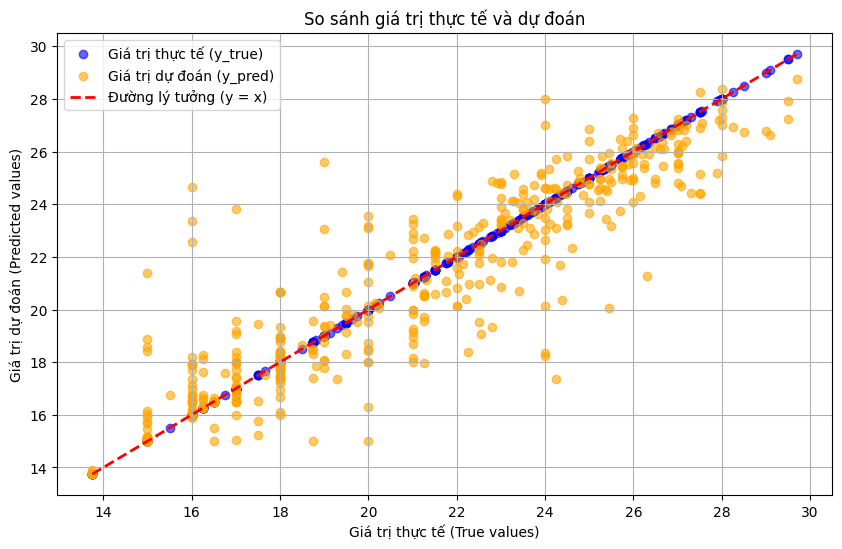

In [328]:
y_true = label_test
y_pred = final_model.predict(feature_test)

plt.figure(figsize=(10, 6))

# điểm thực tế
plt.scatter(y_true, y_true, alpha=0.6, color='blue', label='Giá trị thực tế (y_true)')

# điểm dự đoán
plt.scatter(y_true, y_pred, alpha=0.6, color='orange', label='Giá trị dự đoán (y_pred)')

# Đường chéo lý tưởng
plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--', lw=2, label='Đường lý tưởng (y = x)')

plt.xlabel('Giá trị thực tế (True values)')
plt.ylabel('Giá trị dự đoán (Predicted values)')
plt.title('So sánh giá trị thực tế và dự đoán')
plt.legend()
plt.grid(True)
plt.show()
